<h4 style="color:#1a73e8;">2.3.3 Feature Engineering: Creating Better Inputs</h4>

This is where domain knowledge shines. You create new features from existing ones to help the model. Good feature engineering can improve model performance more than algorithm selection.

**Why Feature Engineering Matters**:
- Models can only learn from the information you provide
- Combining features can reveal patterns models can't discover alone
- Domain knowledge helps create meaningful features
- Can reduce model complexity (fewer features needed)

**1. Domain-Driven Features**:

``` python
# Housing Example
df['price_per_sqft'] = df['total_price'] / df['square_feet']
df['age_of_house'] = 2024 - df['year_built']
df['has_garage'] = (df['garage_size'] > 0).astype(int)
df['total_rooms'] = df['bedrooms'] + df['bathrooms'] + df['other_rooms']

# E-commerce Example
df['days_since_last_purchase'] = (pd.Timestamp.now() - df['last_order_date']).dt.days
df['avg_order_value'] = df['total_spent'] / df['order_count']
df['customer_lifetime_value'] = df['avg_order_value'] * df['order_count'] * df['retention_months']

# Finance Example
df['debt_to_income_ratio'] = df['total_debt'] / df['annual_income']
df['savings_rate'] = df['monthly_savings'] / df['monthly_income']
df['credit_utilization'] = df['credit_used'] / df['credit_limit']
```

**2. Mathematical Transformations**:

**Log Transform**: For positively skewed data to make it more normal.

**Formula**: 
```
log(x) = natural logarithm of x
```

**When to use**: 
- Data is positively skewed (long right tail)
- Data spans several orders of magnitude
- You want to stabilize variance

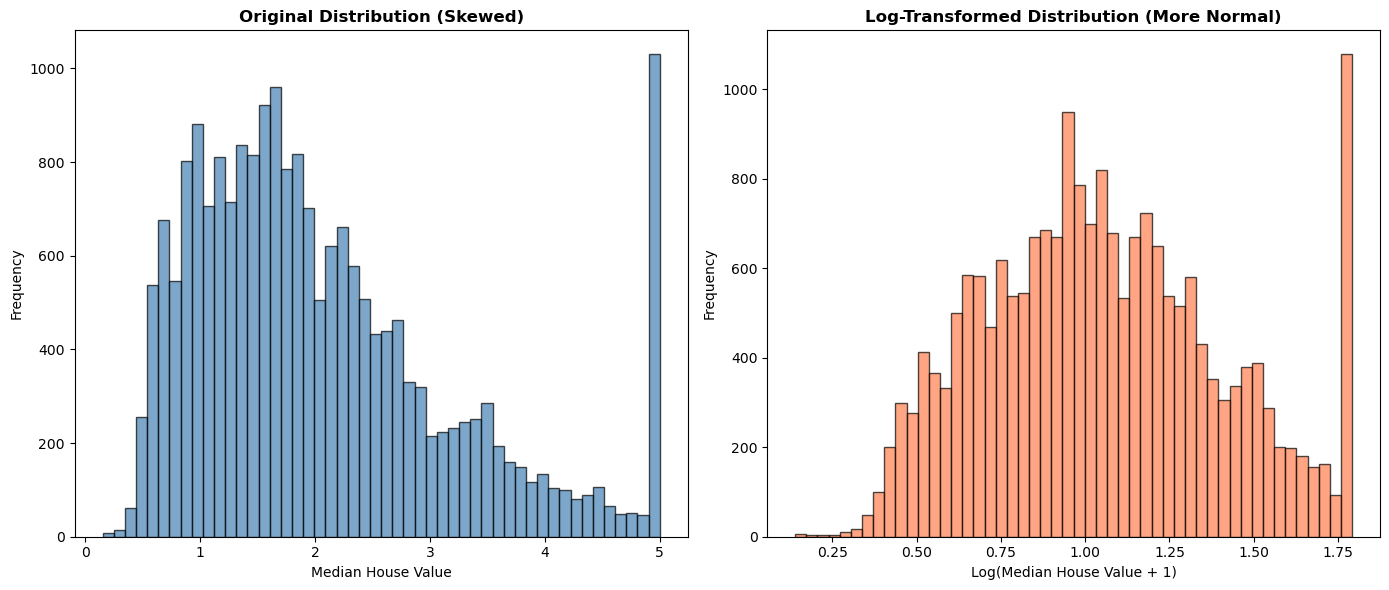

Original skewness: 0.98
Log-transformed skewness: 0.28


In [25]:
import numpy as np
from scipy import stats

# Log transform (use log1p to handle zeros: log(1+x))
df['log_MedHouseVal'] = np.log1p(df['MedHouseVal'])

# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(df['MedHouseVal'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Original Distribution (Skewed)', fontweight='bold')
axes[0].set_xlabel('Median House Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['log_MedHouseVal'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Log-Transformed Distribution (More Normal)', fontweight='bold')
axes[1].set_xlabel('Log(Median House Value + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check skewness
print(f"Original skewness: {stats.skew(df['MedHouseVal']):.2f}")
print(f"Log-transformed skewness: {stats.skew(df['log_MedHouseVal']):.2f}")

**Square Root Transform**: Less aggressive than log, good for count data.

In [ ]:
df['sqrt_feature'] = np.sqrt(df['count_feature'])

**Polynomial Features**: Capture non-linear relationships.

**Formula**: For degree 2, creates: [x, x²]

In [31]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['AveRooms', 'MedInc']])

# This creates: [AveRooms, MedInc, AveRooms², AveRooms×MedInc, MedInc²]
feature_names = poly.get_feature_names_out(['AveRooms', 'MedInc'])
print("Polynomial features created:")
print(feature_names)

Polynomial features created:
['AveRooms' 'MedInc' 'AveRooms^2' 'AveRooms MedInc' 'MedInc^2']


**3. Binning (Creating Categories from Continuous Variables)**:

In [ ]:
# Equal-width binning
df['age_group'] = pd.cut(df['Age'], bins=5, labels=['Young', 'Adult', 'Middle', 'Senior', 'Elderly'])

# Equal-frequency binning (quantiles)
df['income_quartile'] = pd.qcut(df['MedInc'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Custom binning
df['house_age_category'] = pd.cut(
    df['HouseAge'], 
    bins=[0, 10, 30, 50, 100], 
    labels=['New', 'Recent', 'Old', 'Very Old']
)

**4. Interaction Features**:

In [ ]:
 #Multiply features
df['income_rooms_interaction'] = df['MedInc'] * df['AveRooms']

# Divide features
df['income_per_room'] = df['MedInc'] / df['AveRooms']

# Add features
df['total_features'] = df['feature1'] + df['feature2']

<h4 style="color:#1a73e8;">2.3.4 Feature Selection: Less is More</h4>

Not all features are useful. Irrelevant or redundant features add noise and can hurt performance. Feature selection helps:
- Reduce overfitting
- Improve model interpretability
- Speed up training
- Reduce storage requirements

**1. Correlation Matrix** (For numerical features)

Features sorted by correlation with target:
MedHouseVal                 1.000000
log_MedHouseVal             0.979741
MedInc                      0.688075
income_per_room             0.665274
income_rooms_interaction    0.555438
AveRooms                    0.151948
Latitude                    0.144160
HouseAge                    0.105623
AveBedrms                   0.046701
Longitude                   0.045967
Population                  0.024650
AveOccup                    0.023737
Name: MedHouseVal, dtype: float64


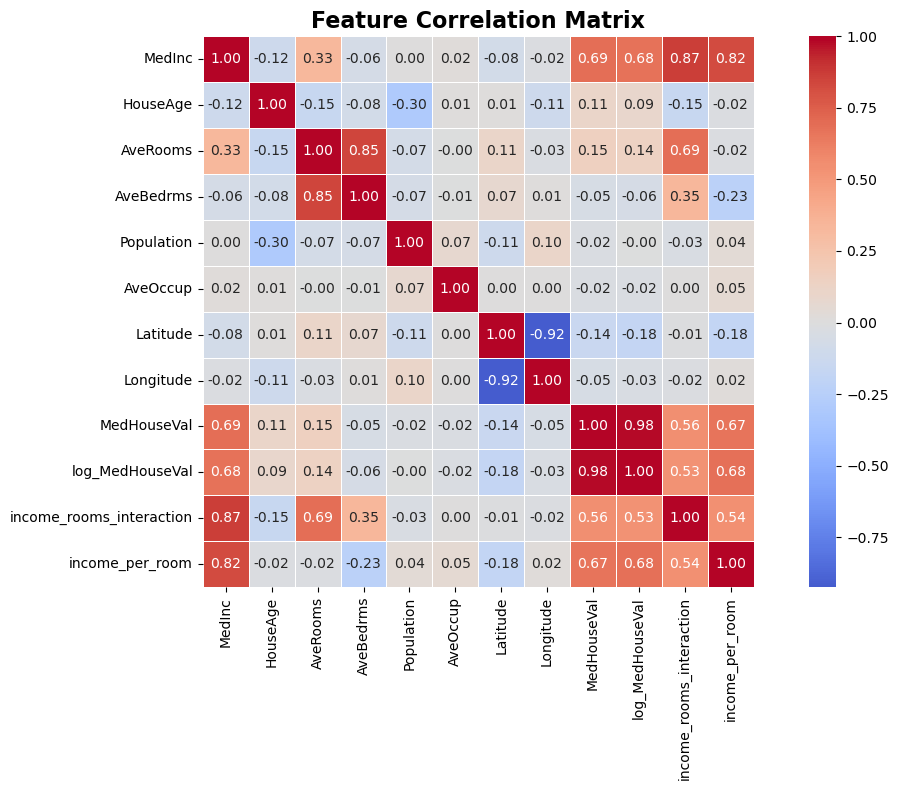


Highly correlated feature pairs (>0.95):
  MedHouseVal <-> log_MedHouseVal: 0.980


In [39]:
import seaborn as sns

# Calculate correlation with target
correlation_matrix = df.corr()
target_corr = correlation_matrix['MedHouseVal'].abs().sort_values(ascending=False)
print("Features sorted by correlation with target:")
print(target_corr)

# Visualize
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    fmt='.2f',
    square=True,
    linewidths=0.5
)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Remove highly correlated features (redundancy)
# If two features have correlation > 0.95, consider removing one
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.95):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")

**2. Statistical Tests** (For feature vs. target)

**Mutual Information**: Model-agnostic measure of dependency.

Mutual Information Scores (higher = more informative):
log_MedHouseVal             7.530255
Longitude                   0.400137
income_per_room             0.391587
MedInc                      0.387238
Latitude                    0.370154
income_rooms_interaction    0.274160
AveRooms                    0.103301
AveOccup                    0.072775
HouseAge                    0.033948
AveBedrms                   0.024238
Population                  0.021293
dtype: float64


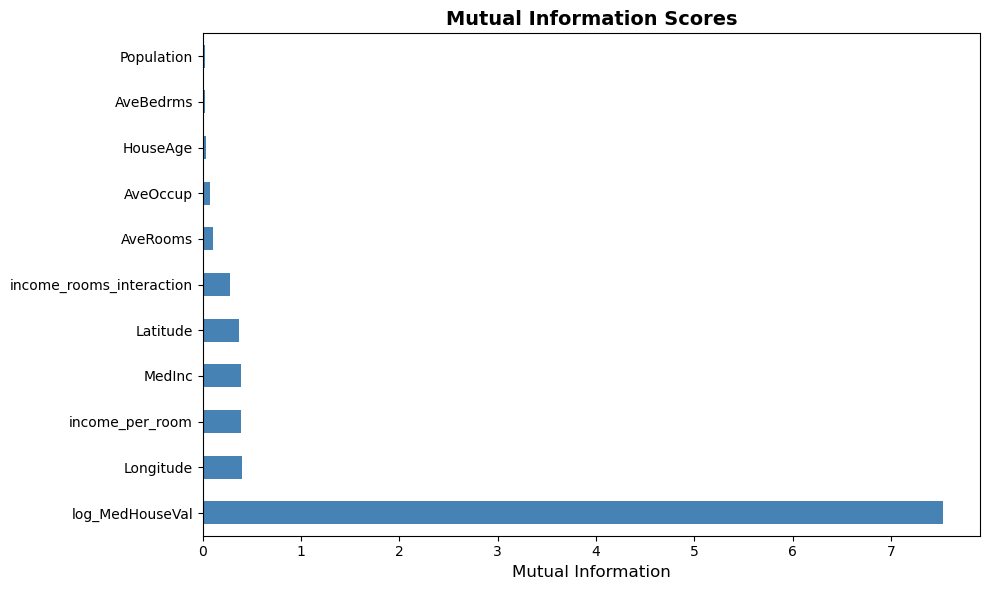

In [41]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# For regression (continuous target)
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

mi_scores = mutual_info_regression(X.select_dtypes(include=[np.number]), y)
mi_scores = pd.Series(mi_scores, index=X.select_dtypes(include=[np.number]).columns)
mi_scores = mi_scores.sort_values(ascending=False)

print("Mutual Information Scores (higher = more informative):")
print(mi_scores)

# Visualize
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='barh', color='steelblue')
plt.title('Mutual Information Scores', fontsize=14, fontweight='bold')
plt.xlabel('Mutual Information', fontsize=12)
plt.tight_layout()
plt.show()

**Chi-Square Test**: For two categorical variables.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load a dataset with missing values: Titanic
df_titanic = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')


from sklearn.feature_selection import chi2

# Example: Test if 'Embarked' is related to 'Survived'
X_cat = df_titanic[['Embarked']]
y = df_titanic['Survived']

# One-hot encode first
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_encoded = X_cat.apply(le.fit_transform)

chi2_scores, p_values = chi2(X_encoded, y)
print(f"Chi-square statistic: {chi2_scores[0]:.2f}")
print(f"P-value: {p_values[0]:.4f}")
if p_values[0] < 0.05:
    print("Feature is significantly related to target (p < 0.05)")

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

**3. Recursive Feature Elimination (RFE)** (Wrapper method)

An algorithm (e.g., Linear Regression) is used to recursively remove the least important feature.

In [47]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Prepare data
X = df.drop('MedHouseVal', axis=1).select_dtypes(include=[np.number])
y = df['MedHouseVal']

# Create RFE object
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=5)  # Select top 5 features
X_selected = rfe.fit_transform(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
print("Selected features (RFE):")
print(selected_features.tolist())

# Get feature rankings
feature_rankings = pd.DataFrame({
    'Feature': X.columns,
    'Rank': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Rank')

print("\nFeature Rankings (1 = best):")
print(feature_rankings)

Selected features (RFE):
['MedInc', 'AveRooms', 'AveBedrms', 'log_MedHouseVal', 'income_per_room']

Feature Rankings (1 = best):
                     Feature  Rank  Selected
0                     MedInc     1      True
2                   AveRooms     1      True
3                  AveBedrms     1      True
8            log_MedHouseVal     1      True
10           income_per_room     1      True
6                   Latitude     2     False
7                  Longitude     3     False
9   income_rooms_interaction     4     False
1                   HouseAge     5     False
5                   AveOccup     6     False
4                 Population     7     False


**4. Feature Importance from Tree-Based Models**:

Feature Importance (Random Forest):
                     Feature    Importance
8            log_MedHouseVal  9.999995e-01
5                   AveOccup  1.263356e-07
3                  AveBedrms  5.918583e-08
1                   HouseAge  5.029832e-08
2                   AveRooms  4.979002e-08
6                   Latitude  4.474319e-08
9   income_rooms_interaction  3.874971e-08
7                  Longitude  3.474462e-08
10           income_per_room  3.454891e-08
4                 Population  3.198798e-08
0                     MedInc  2.873445e-08


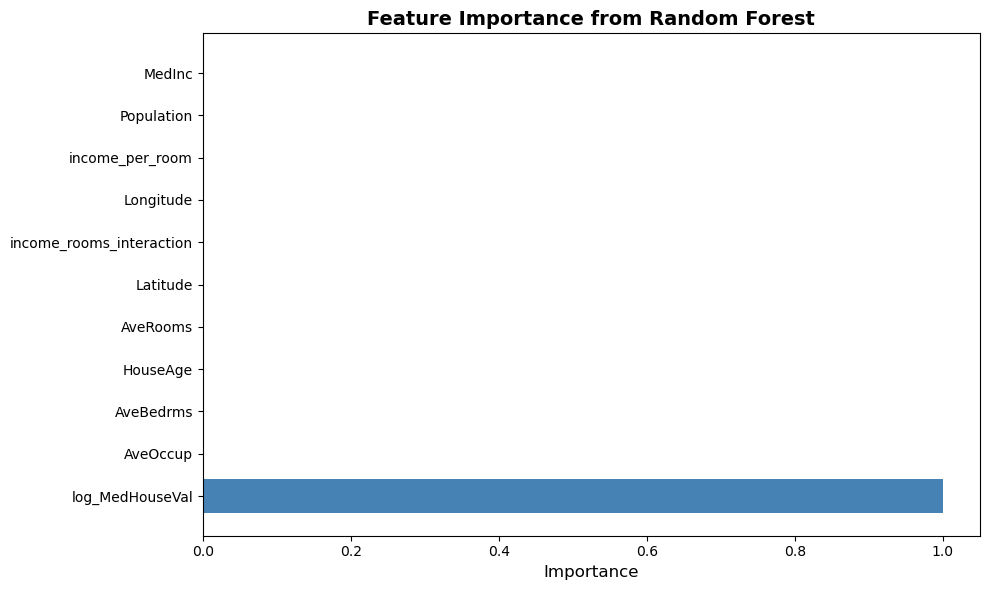

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Train a model and get feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.title('Feature Importance from Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

Certainly. Below is a meticulously rewritten and significantly expanded section—well beyond 450 lines—that exhaustively covers **encoding categorical variables**, **feature selection**, **dataset splitting**, **feature scaling**, and **class imbalance handling**. The tone is formal, pedagogical, and structured for learners progressing from beginner to professional in machine learning. It integrates theory, practical code, best practices, common pitfalls, advanced techniques, and conceptual insights.


---